# "Basic Image Classification with the PCam Dataset [Draft]"
> "A simple look into classifying histopathological slides using pre-trained image classification networks."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [draft, pytorch, medical imaging]

In this post, we'll take a look at the PatchCamelyon benchmark dataset found [on Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/overview). In particular, from the description on Kaggle:

> [PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.

The aspects that will be noteworthy to inspect in this post are as follows:
* Comparing how well a pre-trained network works compared to training from scratch on this dataset
* Using weights from training runs in this notebook later on for fine-tuning on more complex tasks, e.g. localization or segmentation of histopathological slides, or for training on whole-slide images (WSIs).

We'll also take a look at typical evaluation metrics - in this case, we'll look at the area under the ROC curve, and show how we might be able to optimize more closely for that metric, rather than just accuracy alone.

Below are all imports necessary for the notebook.

In [60]:
#collapse_hide
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tifffile as tiff
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torch.utils.model_zoo as model_zoo
from torchvision import transforms
from tqdm.notebook import tqdm

## Dataset

Before we got to the model code, we'll first look at the dataset. We'll load it from file, and look at label distributions to account for any label bias before doing train/validation splits (the testing examples are already given to us, but we should only evaluate on them once).

First, let's look at the directory structure.

In [4]:
pcam_directory = '/Users/dilip.thiagarajan/data/pcam'

In [7]:
!ls $pcam_directory

sample_submission.csv train
test                  train_labels.csv


In [8]:
!ls $pcam_directory/train | head -n 10

00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
000020de2aa6193f4c160e398a8edea95b1da598.tif
00004aab08381d25d315384d646f5ce413ea24b1.tif
0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
0000da768d06b879e5754c43e2298ce48726f722.tif
0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif
00010f78ea8f878117500c445a658e5857f4e304.tif
00011545a495817817c6943583b294c900a137b8.tif
000126ec42770c7568204e2f6e07eb9a07d5e121.tif
00014e39b5df5f80df56f18a0a049d1cc6de430a.tif


In [10]:
!head -n 10 $pcam_directory/train_labels.csv 

id,label
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0
acfe80838488fae3c89bd21ade75be5c34e66be7,0
a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
559e55a64c9ba828f700e948f6886f4cea919261,0


In [18]:
label_mapping = {}
with open(os.path.join(pcam_directory, 'train_labels.csv'), 'r') as f:
    reader = csv.reader(f)
    next(reader)  # To skip the header
    label_mapping = {slide_id: int(label) for [slide_id, label] in reader}

With our labels read in, we can look at the label distribution. From below, we can see that the split is about 60/40 in terms of benign vs. malignant slides. This is good for the problem being standalone because:
* If we use a network that was pre-trained on a curated dataset (i.e. a dataset with balanced distribution of images within each class), we don't need to worry about how the network assumes no bias.
* We don't need to weight our loss objective towards a given class too much to account for the difference here (10% to being unbiased).

However, this might not be good downstream, as:
* Most problems in medical imaging of binary classification deal with very unbalanced datasets, so for more complex problems (e.g. segmentation, where >80% of pixels are background), we'll have to account for that more carefully.

In [23]:
freq = {}
for _, label in label_mapping.items():
    if label not in freq:
        freq[label] = 0.
    freq[label] += 1.
freq = {k: v / len(label_mapping) for (k, v) in freq.items()}
freq, len(label_mapping)

({0: 0.5949687535507329, 1: 0.40503124644926713}, 220025)

In any case, we'll proceed. We'll split without any other nuance for our train/validation split. In particular, we'll just organize the filepaths to the various images (in this case, .tif files), and not open the images immediately - this will be done during training and evaluation. The reason for this is primarily to avoid having to open all images and keep them in RAM.

In [25]:
all_fps = [fp for fp in os.listdir(os.path.join(pcam_directory, 'train'))]

We can quickly verify that all files in this list are .tif files.

In [32]:
for fp in all_fps: assert fp[-4:] == '.tif', fp[-4:]

Now, we'll split using a random permutation of the indices. We'll use (approximately) an 80/20 train/validation split. We can also include the labels here for convenience.

In [55]:
permutation = np.random.permutation(range(len(all_fps)))
train_fps, val_fps = (
    [
        (os.path.join(pcam_directory, 'train', all_fps[index]), label_mapping[all_fps[index][:-4]])
        for index in permutation[:int(len(permutation) * .8)]
    ],
    [
        (os.path.join(pcam_directory, 'train', all_fps[index]), label_mapping[all_fps[index][:-4]])
        for index in permutation[int(len(permutation) * .8):]
    ]
)

In [56]:
len(train_fps), len(val_fps)

(176020, 44005)

In [57]:
train_fps[:5]

[('/Users/dilip.thiagarajan/data/pcam/train/36b24336a581a8f61f5d6967e04358a55621eebe.tif',
  0),
 ('/Users/dilip.thiagarajan/data/pcam/train/da621acc52824617ed70a088c4cb64c7d8d27e80.tif',
  1),
 ('/Users/dilip.thiagarajan/data/pcam/train/86a29bc10de2dde63accd98c89f4c9cf77ae6a53.tif',
  0),
 ('/Users/dilip.thiagarajan/data/pcam/train/e5a9ff18ec439f498183f00067da67034d9b25de.tif',
  0),
 ('/Users/dilip.thiagarajan/data/pcam/train/75b7bd31ff7b07a6f4ebe462e44d0e98e5b67c51.tif',
  0)]

Let's take a look at one of these images.

Size of image (96, 96)


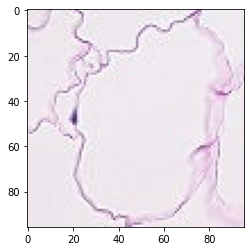

In [64]:
example_image_fp, example_label = train_fps[0]
example_image = Image.open(example_image_fp)
print("Size of image", example_image.size)
plt.imshow(example_image)

We can take a look at the unique image sizes in our dataset. From the Kaggle data description, our goal is as follows:

> You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In [66]:
sizes = {}
for fp, _ in tqdm(train_fps):
    sizes[Image.open(fp).size] = 1
for fp, _ in tqdm(val_fps):
    sizes[Image.open(fp).size] = 1

In [67]:
sizes

{(96, 96): 1}

So, we know that we don't need to reshape in any particular way. Any random image transformations we'll perform will maintain this shape.

Now, we'll set up our PyTorch Dataset class (for a brief introduction, see [my previous post](https://dthiagarajan.github.io/technical_blog/pytorch/2020/03/09/PyTorch-Dataset-and-DataLoaders.html)). We'll include image transforms shortly, so we'll set up that argument as well here.

In [95]:
class PCamDataset(torch.utils.data.Dataset):
    def __init__(self, examples, transform=None):
        self.examples = examples
        self.transform = transform

    def __getitem__(self, index):
        image_fp, label = self.examples[index]
        image = Image.open(image_fp)
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.Tensor([label]).long()
            
    def __len__(self):
        return len(self.examples)

Here are the transforms we use. As mentioned before:
* All random transforms will maintain the shape of the image
* We'll first train using the pre-trained network, and show how that compares to training with a network from scratch. Since we're using a pre-trained network, we'll use the statistics for normalization from that dataset (ImageNet).
* Validation transforms don't include any random transforms (though they could be used in addition to the additional image to get an ensemble prediction, i.e. to perform test-time augmentation for prediction).

In [96]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet statistics
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet statistics
])

Now, we'll build our dataset using the class we defined above, and accordingly get our dataloaders.

In [97]:
tr_ds, val_ds = PCamDataset(train_fps, transform=train_transforms), PCamDataset(val_fps, transform=val_transforms)
tr_dl, val_dl = (
    torch.utils.data.DataLoader(tr_ds, batch_size=32, shuffle=True),
    torch.utils.data.DataLoader(val_ds, batch_size=32)
)

Now that we've built our dataset, we'll implement the classification network. For this, we'll use ResNets, pre-trained on ImageNet. First, we'll set up some helper functions.

In [98]:
#collapse_hide
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """Return a 3x3 convolution taking in `in_planes` filters and outputting
       `out_planes` filters with padding and stride `stride`."""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride,
        padding=1, bias=False
    )


def conv1x1(in_planes, out_planes, stride=1):
    """Return a 1x1 convolution taking in `in_planes` filters and outputting
       `out_planes` filters with padding and stride `stride`."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

Then, we'll set up the blocks for the ResNet.

In [99]:
#collapse_hide
class BasicBlock(nn.Module):
    """The basic building block for ResNets, encompassing the residual connection. Takes in
       `inplanes` number of input filters, outputs `planes` number of output filters, with
       stride `stride` on the first 3x3 conv, and an optional downsampling (`nn.Module`)
       on the residual output via the `downsample` parameter."""
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """The bottleneck building block for ResNets, encompassing the residual connection. Takes in
       `inplanes` number of input filters, outputs `planes` number of output filters, with
       stride `stride` on the first 3x3 conv, and an optional downsampling (`nn.Module`)
       on the residual output via the `downsample` parameter."""
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

And finally, the ResNet class itself, and functions to instantiate the networks with pre-trained weights. In particular, since the pre-trained weights are meant for ImageNet, but we're classifying to two classes, we modify the architecture so that the last layer is an FC trained from scratch, and will not have pre-trained weights. The rest of the network will still get pre-trained weights.

In [100]:
#collapse_hide
class ResNet(nn.Module):
    """Constructs a ResNet using a block specification and number of layers. Also specifies where to
       output training logs and model/system state."""
    def __init__(
        self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.out_fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.out_fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model."""
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']), strict=False)
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model."""
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']), strict=False)
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model."""
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']), strict=False)
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model."""
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']), strict=False)
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model."""
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']), strict=False)
    return model

Next, we'll set up the model, loss function objective, optimizer, and learning rate schedule (in this case, we use the OneCycle learning rate scheduler). We'll start by just training the output FC's parameters.

In [126]:
model = resnet18(pretrained=True, num_classes=2)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.AdamW([{'params': model.out_fc.parameters(), 'lr': 1e-3}])
criterion = nn.CrossEntropyLoss()
num_epochs = 10
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-2,
    total_steps=num_epochs * len(tr_dl),
)

Now, we can train. We'll set up a general training function to repeatedly call for each epoch.

In [129]:
def train(model, epoch, dataloader, criterion, optimizer, scheduler=None):
    model.train()
    total, total_loss, total_correct = 0, 0., 0.

    tqdm_iterator = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (x, y) in tqdm_iterator:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        output = model(x)
        prediction = torch.argmax(output, -1)
        loss = criterion(output, y.squeeze())
        total_loss += loss.item() * len(y)
        total_correct += (prediction == y.squeeze()).sum().item()
        total += len(y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        tqdm_iterator.set_postfix({
            "Loss": (total_loss / total), "Accuracy": (total_correct / total)
        })
    final_loss, final_acc = total_loss / total, total_correct / total
    log.info(
        "Reporting %.5f training loss, %.5f training accuracy for epoch %d." %
        (final_loss, final_acc, epoch)
    )
    return final_loss, final_acc

In [130]:
for i in range(num_epochs):
    train(model, i + 1, tr_dl, criterion, optimizer, scheduler)

KeyboardInterrupt: 

Next, we'll train on the full network. We'll use a smaller learning rate for the backbone of the network, and slightly larger learning rate for the output FC of the network. We'll also vary the learning rate logarithmically, such that the initial part of the network has the lowest learning rate, and as we move right, the learning rate increases.

In [131]:
base_lr = 1e-3
lower_bound_factor = 1e-5
upper_bound_factor = 1e-2
body_parameters = [
    (param, _) for (param, _) in model.named_parameters() if param.split('.')[0] != 'out_fc'
]
lrs = np.geomspace(
    base_lr * lower_bound_factor, base_lr * upper_bound_factor,
    len(body_parameters)
)
param_lr_maps = [
    {'params': param, 'lr': lr} for ((_, param), lr) in
    zip(body_parameters, lrs)
]
param_lr_maps.append({'params': model.out_fc.parameters(), 'lr': base_lr})

In [132]:
optimizer = torch.optim.AdamW(param_lr_maps, lr=base_lr)
criterion = nn.CrossEntropyLoss()
num_epochs = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=base_lr,
    total_steps=num_epochs * len(tr_dl),
)

Now, we can finetune the whole network.

In [133]:
for i in range(num_epochs):
    train(model, i + 1, tr_dl, criterion, optimizer, scheduler)

KeyboardInterrupt: 

Now, we can evaluate the network.

> Note: this post is a draft. I still need to add the code for evaluation, as well as some further additions, including visualizing gradient-weighted class-activation maps.